# Draft: Trending WFS&C Data with WebbPSF

***

## Imports
 Describe the libraries we're using here. If there's something unusual, explain what the library is, and why we need it.
- *webbpsf* to use the webbpsf trending functions and library as an example
- *astropy* to use various astropy features such as units and time and open fits files
- *os* to use OS level system calls
- *matplotlib* to generate various plots and manipulate them


In [65]:
import numpy as np
import webbpsf
import astropy
import astropy.units as u
from astropy.time import Time
import astropy.io.fits as fits
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

## Introduction
The purpose of this notebook is to provide some examples of how to use the WebbPSF trending API for JWST WFS&C Data.  Code excerpts and text extracted from: [WebbPSF User Docs](https://webbpsf.readthedocs.io/en/latest/jwst_measured_opds.html)

### Defining terms
For more information on JWST Acronyms and abbreviations please see: [JWST Acronyms and Abbreviations](https://jwst-docs.stsci.edu/jwst-acronyms-and-abbreviations)

For more information on JWST Wavefront Sensing and Control: [JWST User Docs](https://jwst-docs.stsci.edu/jwst-observatory-hardware/jwst-wavefront-sensing-and-control)

## References
WebbPSF. (n.d.). JWST Measured OPDs. WebbPSF Documentation. Retrieved July 10, 2024, from https://webbpsf.readthedocs.io/en/latest/jwst_measured_opds.html

***

## Installing WebbPSF and required data files
[Follow installation instructions on WebbPSF](https://webbpsf.readthedocs.io/en/latest/installation.html)

If you install via pip or manually, you must install the data files yourself.

Files containing such information as the JWST pupil shape, instrument throughputs, and aperture positions are distributed separately from WebbPSF. To run WebbPSF, you must download these files and tell WebbPSF where to find them using the WEBBPSF_PATH environment variable.

  1. Download the following file: [webbpsf-data-LATEST.tar](https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz) [approx. 70 MB]

  2. Untar webbpsf-data-LATEST.tar.gz into a directory of your choosing.

  3. Set the environment variable WEBBPSF_PATH to point to that directory. e.g.

## Download Data from MAST

The WFS&C Data is available in MAST: Barbara A. Mikulski Archive for Space Telescopes
The MAST Portal lets you search multiple collections of astronomical datasets all in one place. Use this tool to find astronomical data, publications, and images. [JWST WSS OPDs](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22WSSFILTERED%22%2C%22inputText%22%3A%5B%7B%22isDate%22%3Afalse%2C%22niceName%22%3A%22isRestricted%22%2C%22paramName%22%3A%22isRestricted%22%2C%22valString%22%3A%22%22%2C%22values%22%3A%5B%22false%22%5D%7D%5D%2C%22position%22%3A%22undefined%2C%20undefined%2C%20undefined%22%2C%22paramsService%22%3A%22Mast.Jwst.Filtered.Wss%22%2C%22title%22%3A%22WSS%3A%20%20Advanced%20Search%201%22%2C%22tooltip%22%3A%22%22%2C%22columns%22%3A%22*%22%7D)

WebbPSF uses Astroquery MAST API under the hood to retrieve the OPDs from MAST.  

Here's an example notebook that shows how to use MAST to download science data:
[download_by_program_id.ipynb](https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/JWST/download_by_program_id/download_by_program_id.ipynb) 

WebbPSF does something similar under the hood but uses the service: 

'Mast.Jwst.Filtered.Wss'

[mast_wss.py#L360](https://github.com/spacetelescope/webbpsf/blob/develop/webbpsf/mast_wss.py#L360)

The API handles the transactions so you can download all of the data needed here:

In [66]:
opdtable = webbpsf.mast_wss.retrieve_mast_opd_table()
opdtable = webbpsf.mast_wss.deduplicate_opd_table(opdtable)
webbpsf.mast_wss.download_all_opds(opdtable)

WebbPSF provides various trending features.  Here's an example of how to get a monthly trending plot by specifying the year and the month:

## Monthly Trending Plot

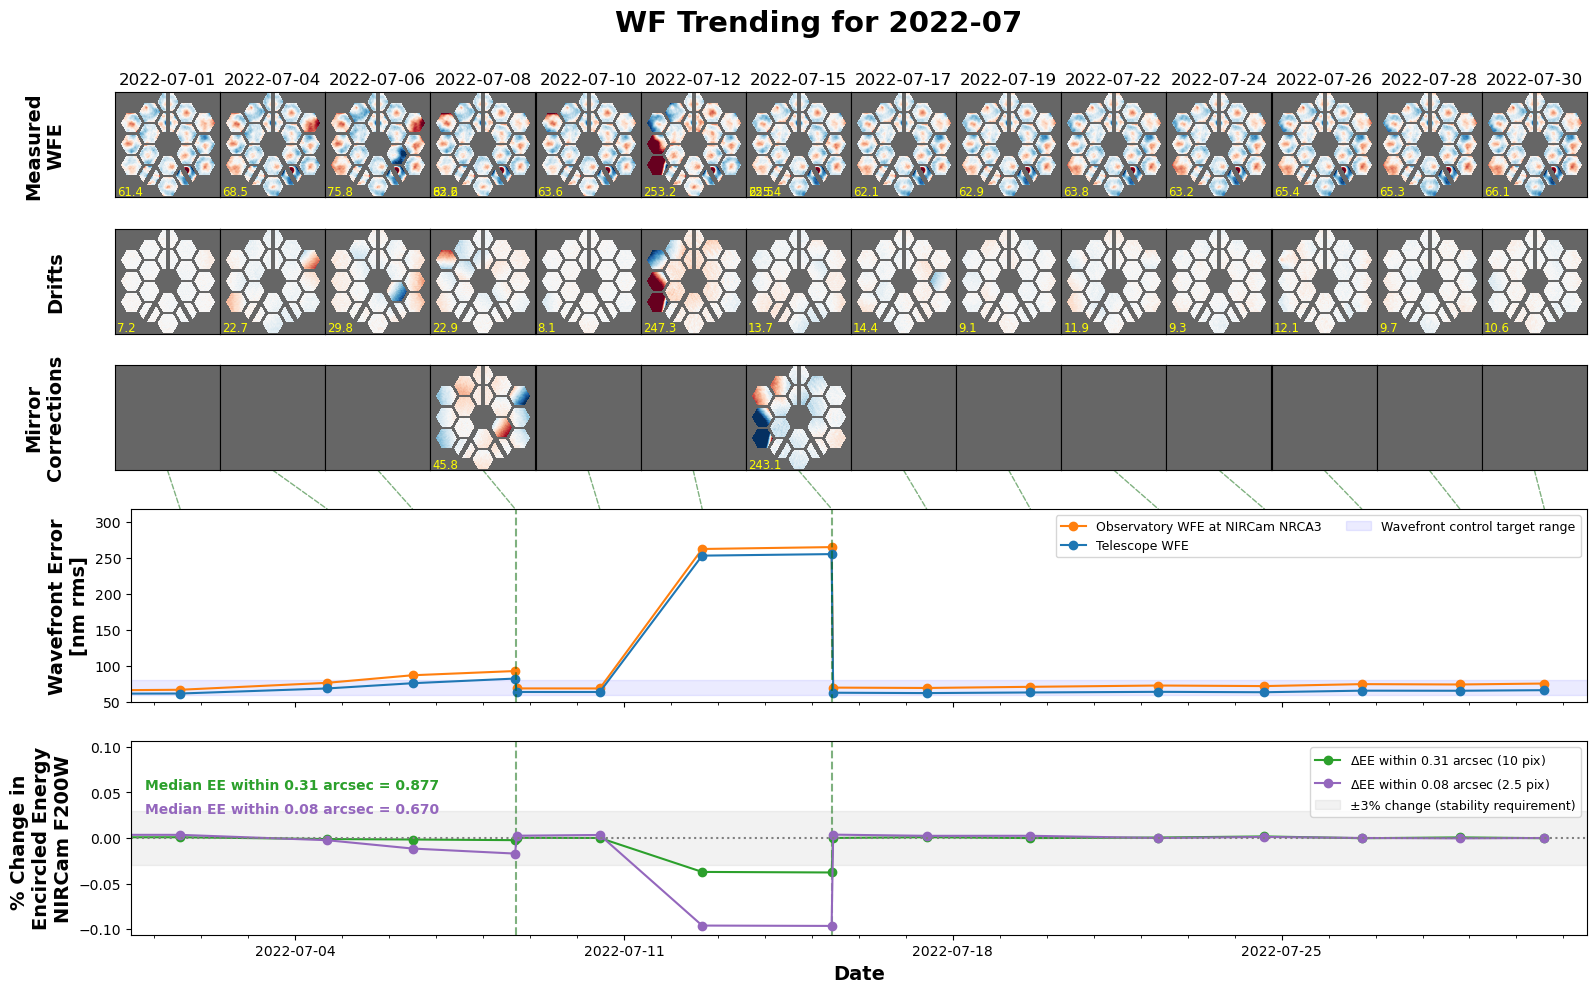

In [67]:
trend_taable = webbpsf.trending.monthly_trending_plot(2022, 7, verbose=False)

The above figure shows:

Each wavefront sensing measurement throughout the specified month (first row)

The drift in wavefront between each two successive measurements (i.e. the changes arising in the telescope itself, without any ground commanding. Second row)

The mirror corrections applied (i.e. the result of mirror move commands sent from the ground. Third row)

Plots of the wavefront RMS value over time, for both the OTE wavefront only (i.e. the waveront quality from the telescope delivered to the NIRCam sensing field point) and the total observatory wavefront (i.e. the sum of telescope and instrument contributions to the wavefront).

Computed values for the encircled energy within radii of 2.5 pixels and 10 pixels, and their variation over time.

In the above plot for 2022 July, we can see that the wavefront was generally stable (very little change from one meaurement to the next, but a few individual mirror tilt events can be seen for instance in the July 4 and July 6 sensing). A wavefront correction was applied on July 8. Then the July 12 wavefront sensing revealed a larger wing tilt event affecting the several segments on the left (-V2) wing. This was corrected in the July 15 wavefront sensing and control observation, and after that the telescope remained stable throughout the rest of that month’s wavefront sensing.

The monthly_trending_plot function automatically saves the plot as a PDF to the current working directory, with filenames like “wf_trending_2022-08.pdf'”

The function also returns a table with information summarizing the available WFS measurements, WFE levels, and computed PSF encircle energies. This can be used to help understand how much the photometry in your observation is affected by PSF changes at a given time.

In [68]:
# Convert astropy table to Pandas dataframe and look at some general statistics
df = trend_table.to_pandas()
df.describe()

,RMS WFE (OTE+SI),RMS WFE (OTE only),EE(2.5 pix),EE(10pix)
count,17.000000,17.000000,17.000000,17.000000
mean,95.923277,88.008585,0.661709,0.873349
std,63.553352,62.817969,0.021611,0.010971
min,65.782227,61.186759,0.605018,0.844029
25%,69.157582,62.908686,0.668024,0.876223
50%,72.562730,63.784308,0.669679,0.877262
75%,76.332696,68.487914,0.671334,0.877817
max,265.083839,255.350104,0.672124,0.878751


## Wavefront time series

Other functions can provide views of wavefront changes over even longer timescales. We can retrieve a table of all available OPDs and plot the measurements over time:

In [69]:
opdtable = webbpsf.mast_wss.retrieve_mast_opd_table()
opdtable = webbpsf.mast_wss.deduplicate_opd_table(opdtable)
webbpsf.mast_wss.download_all_opds(opdtable)

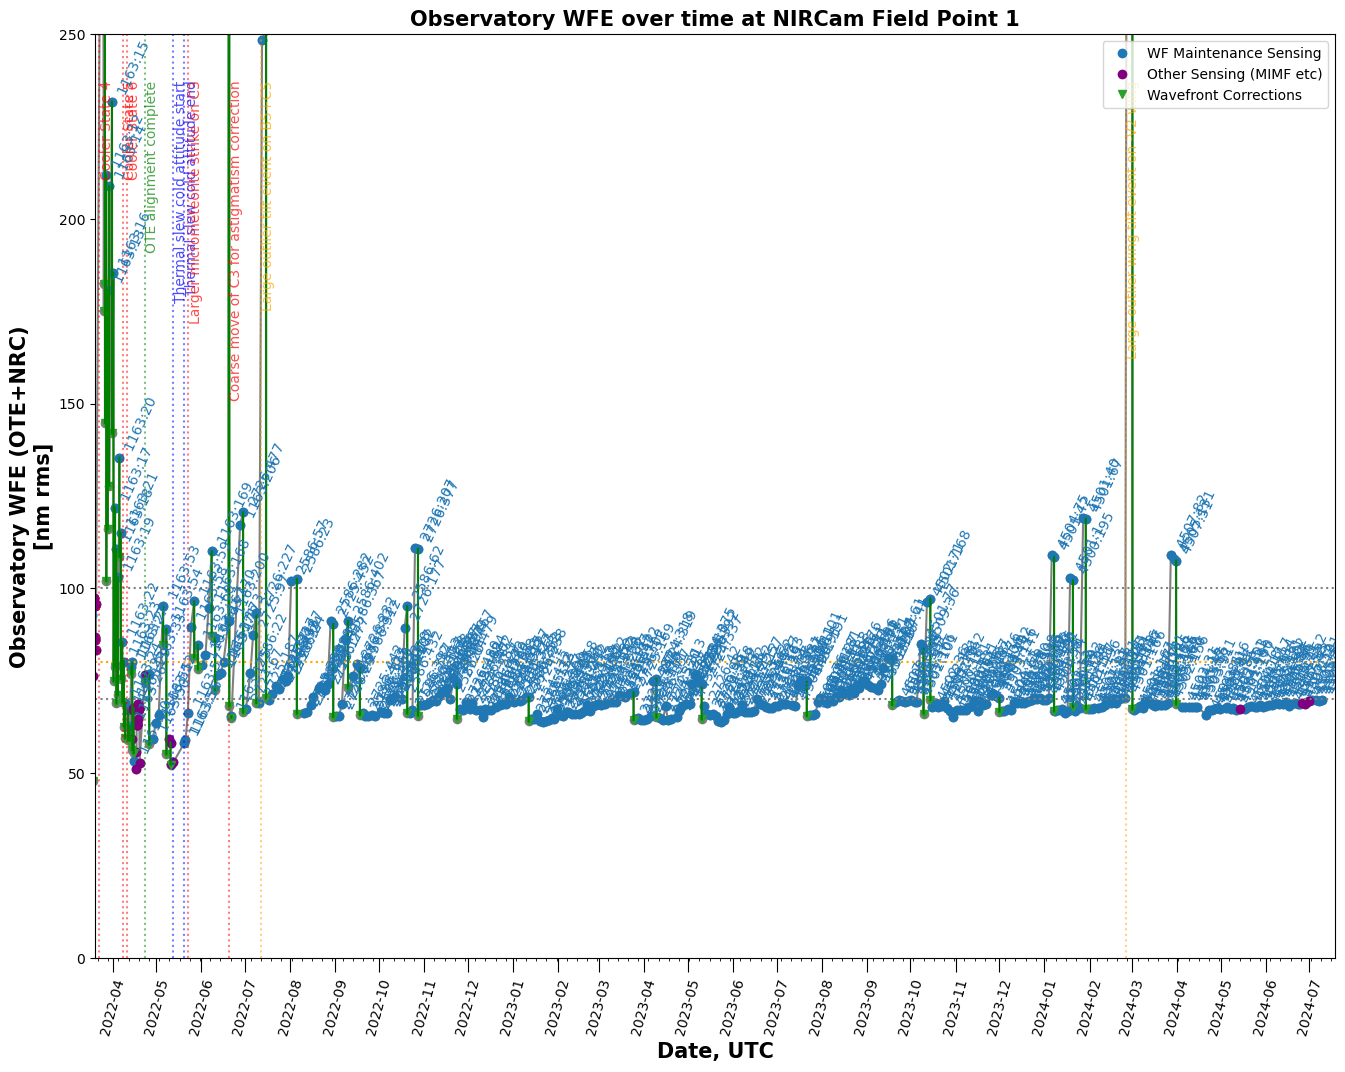

In [70]:
webbpsf.trending.wavefront_time_series_plot(opdtable)

The above shows wavefront drifts and corrections from around the middle of OTE commissioning to the early part of Cycle 1. Rapid drifts and corrections in early March are from the MIRI cryocooler gradually cooling the observatory, until reaching thermal stability in mid April.

Occasional increases in wavefront error from mirror tilts and corrections can be seen in subsequent months. There was an especially large tilt event on July 12, which was corrected on July 15.

We can also plot all measured wavefront drifts over specified time periods.

## Telescope Wavefront Drift plots

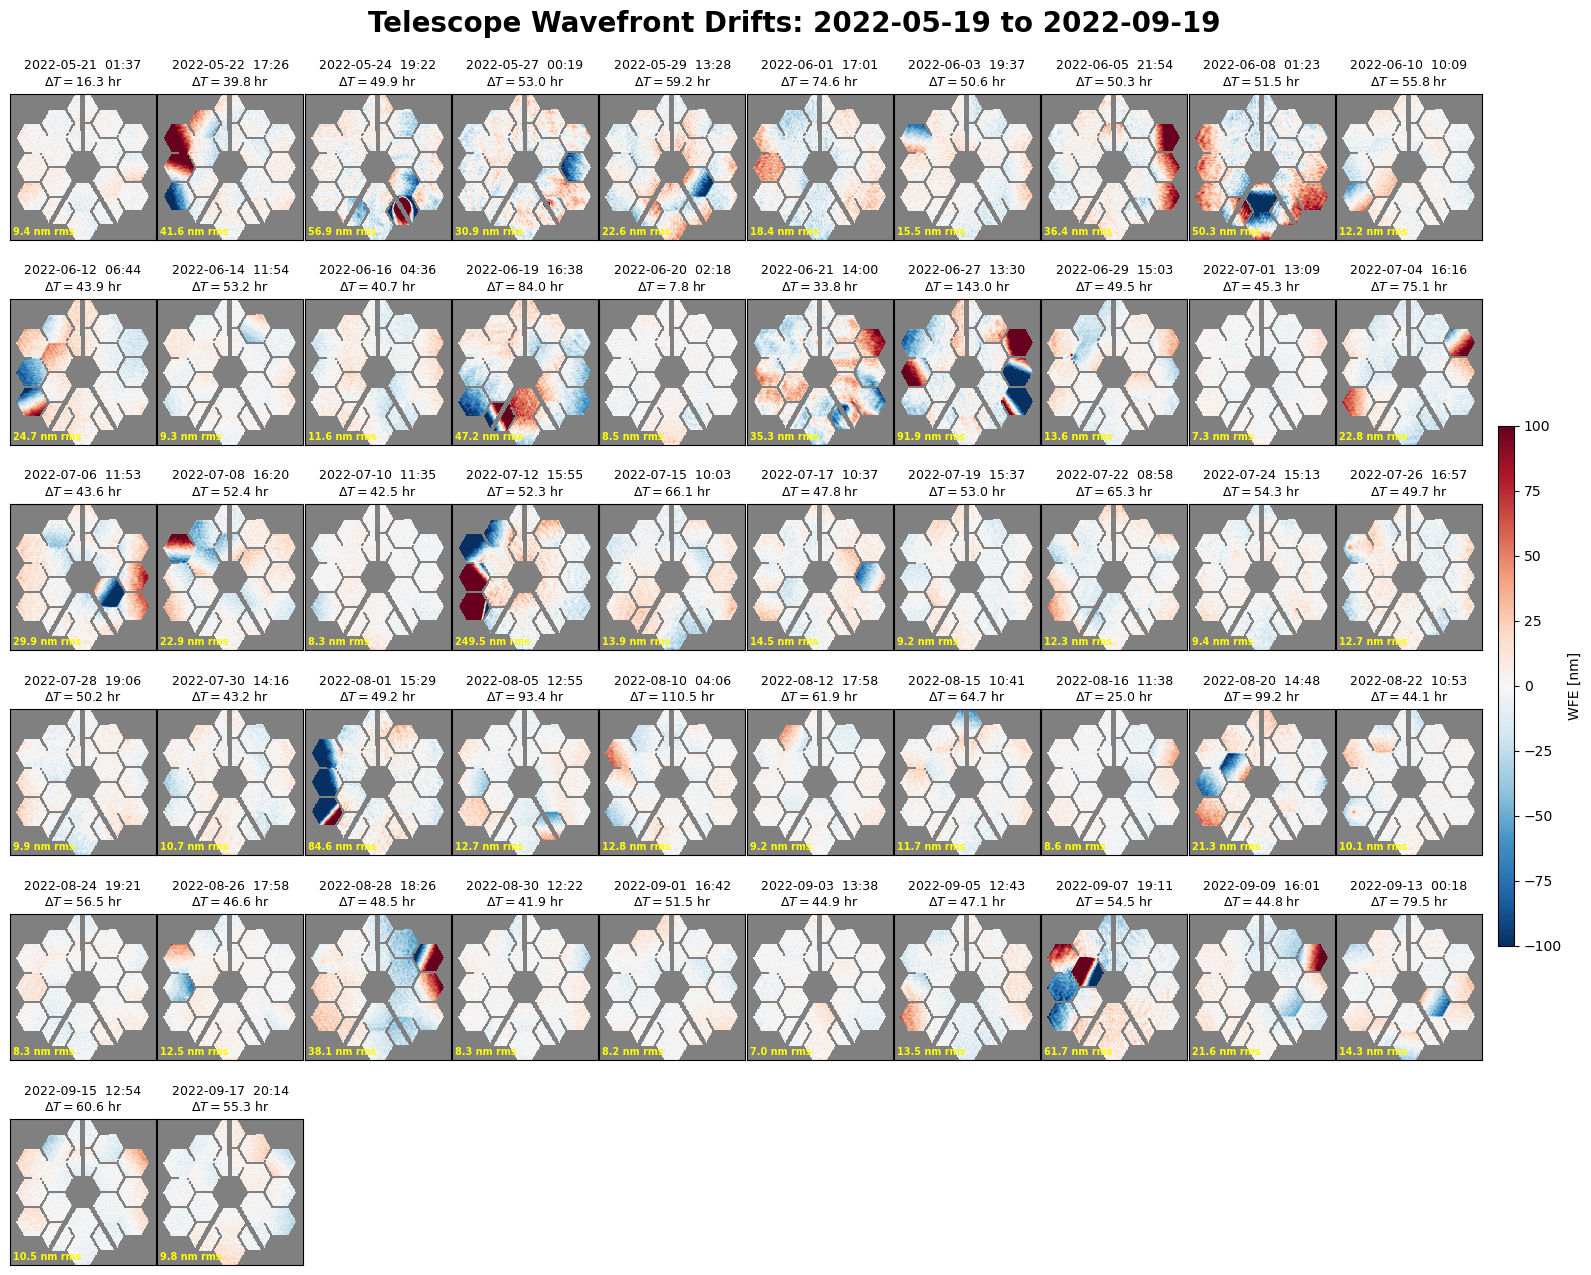

In [71]:
start_time =  astropy.time.Time('2022-05-19T00:00:00')
end_time = astropy.time.Time('2022-09-19T00:00:00')

webbpsf.trending.wavefront_drift_plots(opdtable, start_time=start_time, end_time=end_time, n_per_row=10)

## Wavefront time series and histogram plot

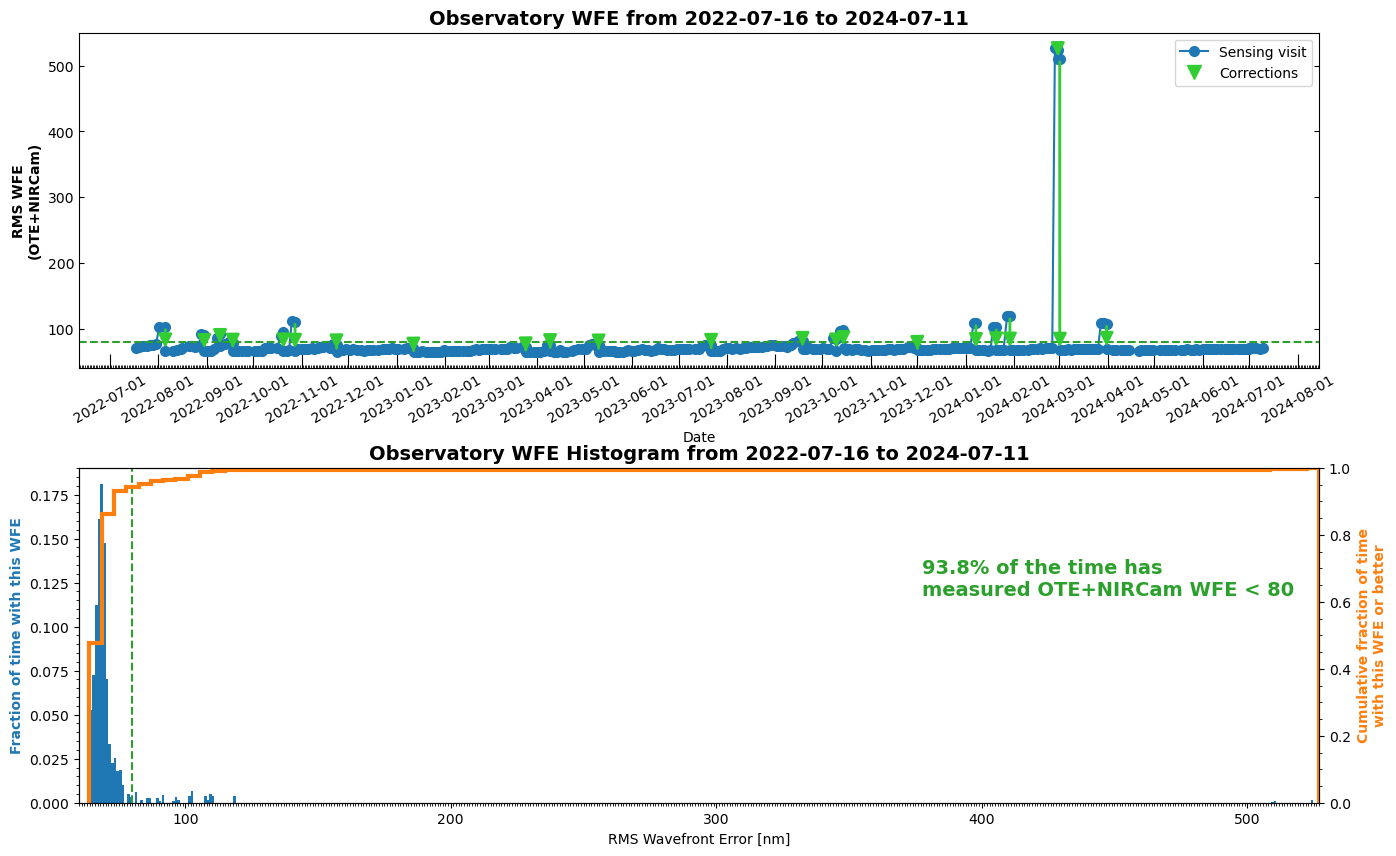

In [72]:
start_time =  astropy.time.Time('2022-07-16')
webbpsf.trending.wfe_histogram_plot(opdtable, start_date=start_time, thresh=80, mark_corrections='arrows')

The above plot shows the wavefront error evolution over the first part of Cycle 1, starting after the ERO release on July 12 and continuing up to present (as of 2022 Dec 13, during the “First Science with JWST” conference). You can see the occasional larger tilt events which are subsequently detected and corrected. It appears possible that the frequency of the larger events may be decreasing over time.

## Show Wavefront Sensing Trends around a science program

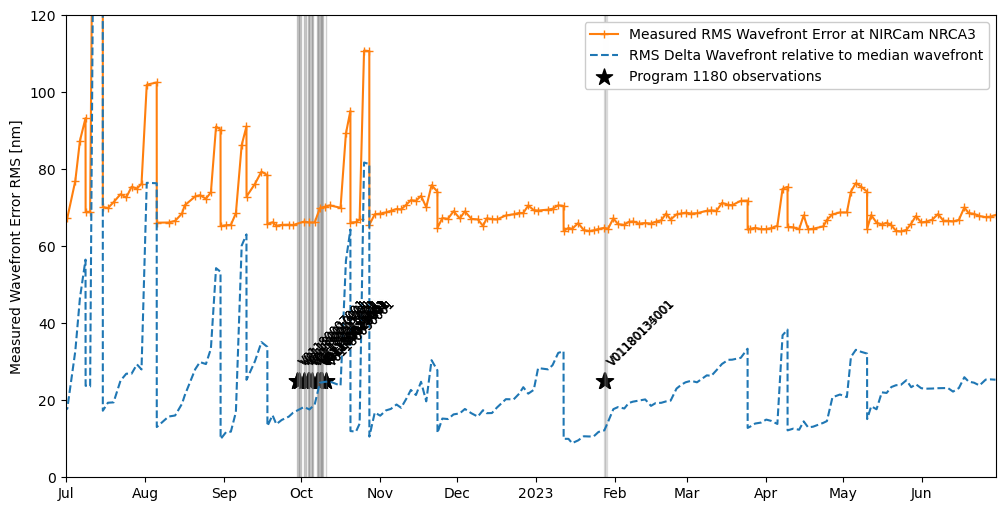

In [73]:
webbpsf.trending.show_wfs_during_program(1180, start_date='2022-07-01', end_date = '2023-06-30')

The stars with text labels and gray vertical lines indicate the times of all observations in that program. (There’s a lot of observations in October so the labels are a bit hard to read in this case.) We can see that, while the telescope had occasional periods of higher wavefront error, all of the JADES observations happened with the telescope wavefront error around its typical value.

The orange line shows the measured total wavefront RMS for each sensing; the blue line shows the RMS difference at each time relative to the median wavefront. In this case, all the JADES observations happened with no more than about 20 nm rms wavefront differences relative to the mean; this is lambda/100 at 2 microns, for instance, which leads to quite stable PSFs.

## Exercises
In this section we will explore the OPDs and the WFS&C Data ourselves by analyzing the RMS WFE using python libraries: pandas and matplotlib.  

In [74]:
## Extract the RMS WFE from the OPD FITS header file 
## TODO: convert this to do pandas apply function
rmses = []
for row in opdtable:
    if os.path.isfile(row['fileName']) is False:
        full_file_path = os.path.join(webbpsf.utils.get_webbpsf_data_path(), 'MAST_JWST_WSS_OPDs', row['fileName'])
    else:
        full_file_path = row['fileName']
    if 'rms_wfe' not in opdtable.colnames:
        rmses.append(fits.getheader(full_file_path, ext=1)['RMS_WFE'])

In [75]:
df = opdtable.to_pandas()
df['rms_wfe'] = rmses
df['rms_wfe'] = df['rms_wfe'] * 1000

In [76]:
df[df.is_post_correction == True]

,date,date_obs_mjd,visitId,activity,apername,corr_id,fileName,dataURI,wfs_measurement_type,is_post_correction,is_pre_correction,rms_wfe
0,2022-03-11T19:37:04.200,59649.817410,V01160001001,02109,NRCA3_FP1,R2022031401,R2022031401-NRCA3_FP1-0.fits,mast:JWST/product/R2022031401-NRCA3_FP1-0.fits,post,True,False,59.15120
4,2022-03-14T15:44:07.500,59652.655642,V01163006001,02107,NRCA3_FP1,R2022031405,R2022031405-NRCA3_FP1-1.fits,mast:JWST/product/R2022031405-NRCA3_FP1-1.fits,post,True,False,51.14070
7,2022-03-17T22:54:02.800,59655.954199,V01163004001,02107,NRCA3_FP1,R2022031801,R2022031801-NRCA3_FP1-1.fits,mast:JWST/product/R2022031801-NRCA3_FP1-1.fits,post,True,False,122.07000
8,2022-03-18T05:18:33.700,59656.221223,V01163005001,02107,NRCA3_FP1,R2022032004,R2022032004-NRCA3_FP1-1.fits,mast:JWST/product/R2022032004-NRCA3_FP1-1.fits,post,True,False,47.90350
26,2022-03-25T23:21:38.500,59663.973362,V01163111001,03104,NRCA3_FP1,O2022032601,O2022032601-NRCA3_FP1-1.fits,mast:JWST/product/O2022032601-NRCA3_FP1-1.fits,post,True,False,175.09400
...,...,...,...,...,...,...,...,...,...,...,...,...
419,2024-01-20T14:00:46.200,60329.583868,V04500195001,03107,NRCA3_FP1,R2024012003,R2024012003-NRCA3_FP1-1.fits,mast:JWST/product/R2024012003-NRCA3_FP1-1.fits,post,True,False,67.84180
425,2024-01-29T10:28:22.200,60338.436368,V04501067001,03107,NRCA3_FP1,R2024012903,R2024012903-NRCA3_FP1-1.fits,mast:JWST/product/R2024012903-NRCA3_FP1-1.fits,post,True,False,67.42420
441,2024-02-29T05:52:32.600,60369.244822,V04556001001,0310C,NRCA3_FP1,R2024022903,R2024022903-NRCA3_FP1-0.fits,mast:JWST/product/R2024022903-NRCA3_FP1-0.fits,post,True,False,509.63527
443,2024-03-01T10:24:14.000,60370.433495,V04556002001,0310C,NRCA3_FP1,R2024030104,R2024030104-NRCA3_FP1-1.fits,mast:JWST/product/R2024030104-NRCA3_FP1-1.fits,post,True,False,67.25910


In [77]:
df['rms_wfe'].describe()

count    509.000000
mean      81.834257
std       56.566212
min       47.903500
25%       66.942900
50%       68.721000
75%       73.823200
max      536.800000
Name: rms_wfe, dtype: float64

In [78]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [79]:
reset_mask = df.is_post_correction == True
groups = reset_mask.cumsum()
df['Cumulative_Diff'] = df.groupby(groups)['rms_wfe'].diff().fillna(df['rms_wfe'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


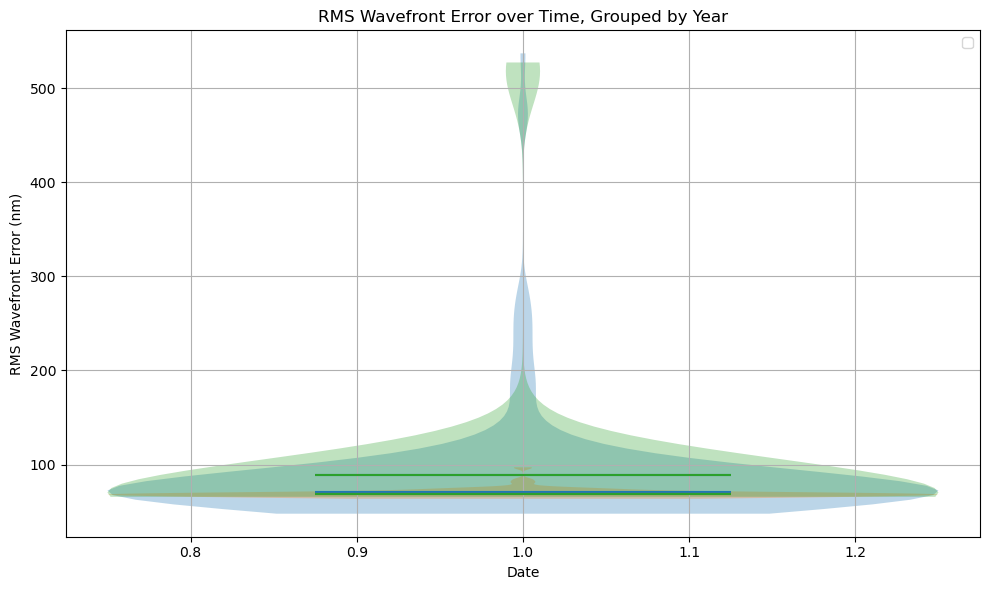

In [96]:
grouped = df.groupby('year')

# Plotting
plt.figure(figsize=(10, 6))

for year, group in grouped:
    #plt.plot(group['date'], group['rms_wfe'], label=f'Year {year}')
    plt.violinplot(group['rms_wfe'], showmeans=True, showextrema=False, showmedians=True)

plt.xlabel('Date')
plt.ylabel('RMS Wavefront Error (nm)')
plt.title('RMS Wavefront Error over Time, Grouped by Year')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

ValueError: 'locs' must be 1D with shape (N,), but your input has shape ()

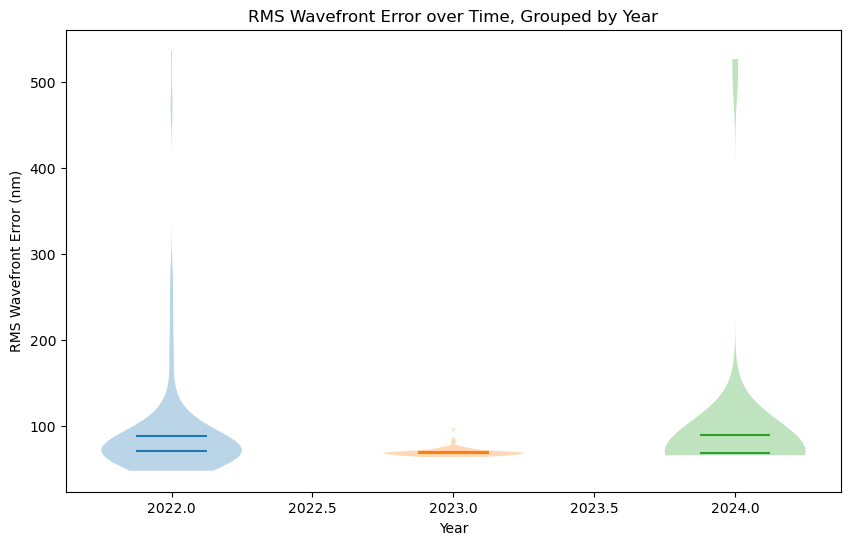

In [97]:
# Plotting
plt.figure(figsize=(10, 6))

# Create a separate violin plot for each year
for year, group in grouped:
    plt.violinplot(group['rms_wfe'], positions=[year], showmeans=True, showextrema=False, showmedians=True)

# Customizing the plot
plt.xlabel('Year')
plt.ylabel('RMS Wavefront Error (nm)')
plt.title('RMS Wavefront Error over Time, Grouped by Year')
plt.xticks(ticks=grouped.groups.keys(), labels=grouped.groups.keys())
plt.grid(True)
plt.tight_layout()

plt.show()

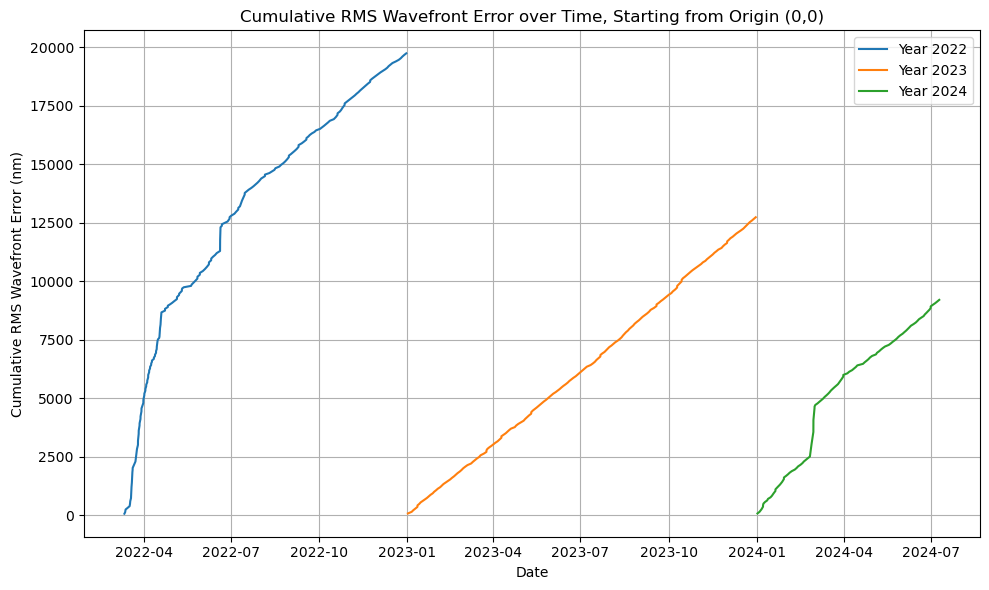

In [81]:
grouped = df.groupby('year')

# Plotting
plt.figure(figsize=(10, 6))

for year, group in grouped:
    # Calculate cumulative sum of RMS WFE values for each year
    cumulative_rms_wfe = np.cumsum(group['rms_wfe'])
    plt.plot(group['date'], cumulative_rms_wfe, label=f'Year {year}')

plt.xlabel('Date')
plt.ylabel('Cumulative RMS Wavefront Error (nm)')
plt.title('Cumulative RMS Wavefront Error over Time, Starting from Origin (0,0)')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

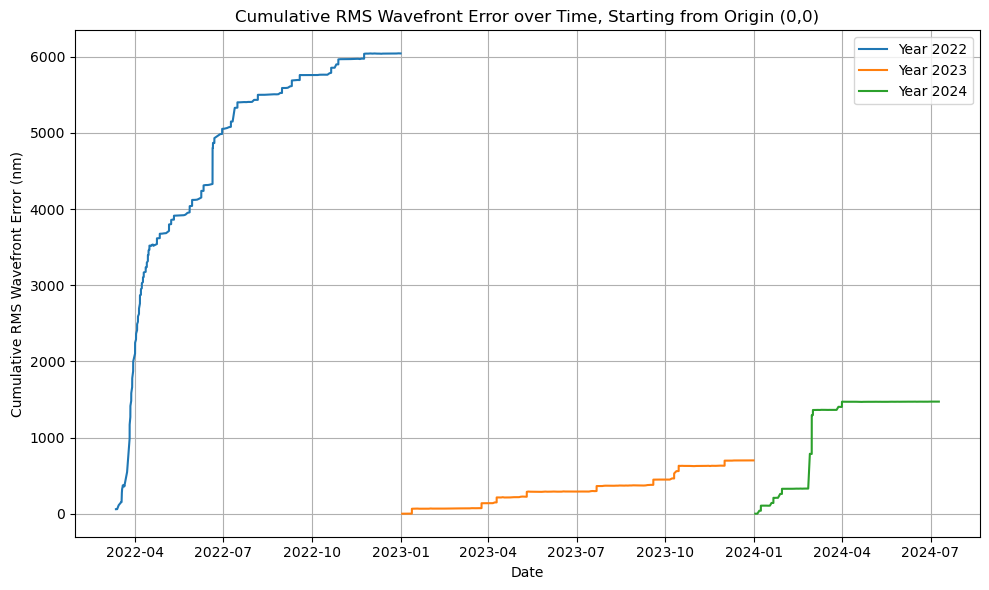

In [82]:
grouped = df.groupby('year')

# Plotting
plt.figure(figsize=(10, 6))

for year, group in grouped:
    # Calculate cumulative sum of RMS WFE values for each year
    cumulative_rms_wfe = np.cumsum(group['Cumulative_Diff'])
    plt.plot(group['date'], cumulative_rms_wfe, label=f'Year {year}')

plt.xlabel('Date')
plt.ylabel('Cumulative RMS Wavefront Error (nm)')
plt.title('Cumulative RMS Wavefront Error over Time, Starting from Origin (0,0)')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

{'bodies': [<matplotlib.collections.PolyCollection at 0x1a8d699f0>],
 'cmeans': <matplotlib.collections.LineCollection at 0x1a8d699c0>,
 'cmedians': <matplotlib.collections.LineCollection at 0x1a8d6a0e0>}

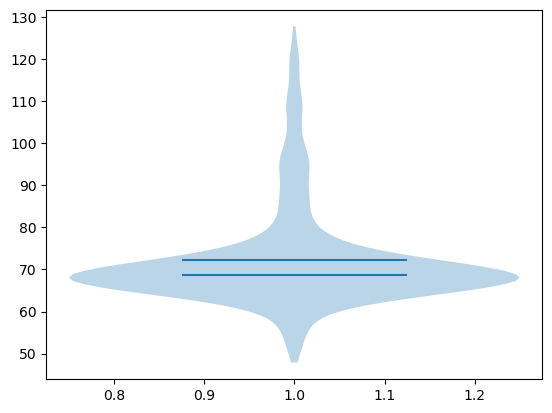

In [83]:
data = df[df['rms_wfe'] < 131.0]
plt.violinplot(data['rms_wfe'], showmeans=True, showextrema=False, showmedians=True)

In [84]:
data.describe()

,date,date_obs_mjd,rms_wfe,year,Cumulative_Diff
count,488,488.000000,488.000000,488.000000,488.000000
mean,2023-03-27 07:35:13.268032512,60030.316126,72.232846,2022.782787,10.138620
min,2022-03-11 19:37:04.200000,59649.817410,47.903500,2022.000000,-14.614200
25%,2022-07-14 05:01:54.975000064,59774.209664,66.847225,2022.000000,-0.147975
50%,2023-03-23 11:19:18.500000,60026.471742,68.634500,2023.000000,0.323950
75%,2023-11-16 13:48:02.075000064,60264.575024,72.487825,2023.000000,2.937875
max,2024-07-09 14:56:29.900000,60500.622568,127.713000,2024.000000,127.713000
std,NaN,265.401199,12.021741,0.759573,23.733792


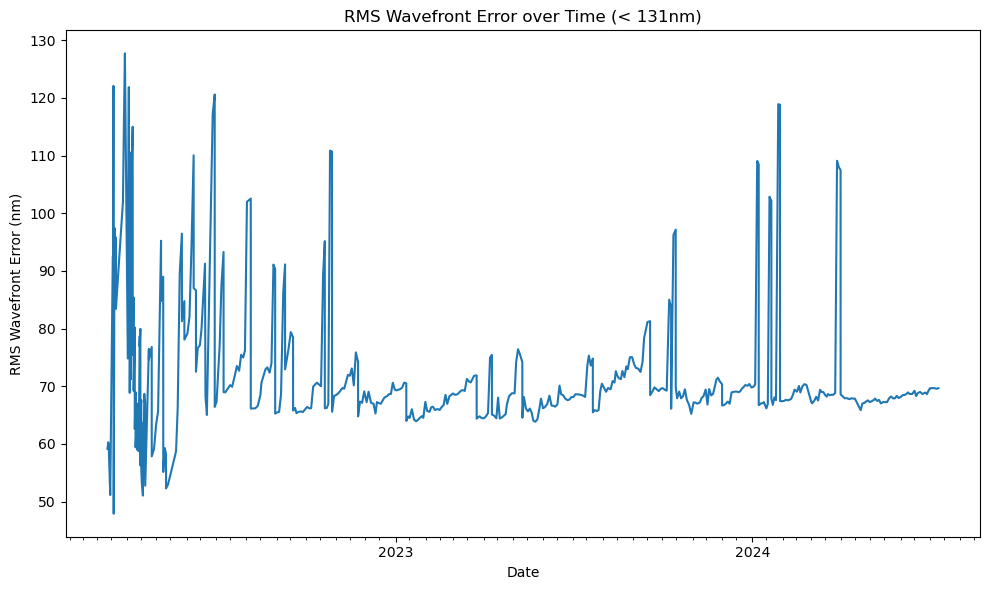

In [92]:
# TODO: fix the x-axis so it shows the dates better
import matplotlib.dates as mdates
#data.plot(x='date', y='rms_wfe')
# Plotting
fig = plt.figure(figsize=(10, 6))

plt.plot(data['date'], data['rms_wfe'])

plt.xlabel('Date')
plt.ylabel('RMS Wavefront Error (nm)')
plt.title('RMS Wavefront Error over Time (< 131nm)')
plt.tight_layout()
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(bymonthday=[1, 15]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

## Aditional Resources


- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook)
- [WebbPSF Documentation](https://webbpsf.readthedocs.io/en/latest/intro.html)

## About this notebook
**Author:** Trey Kulp, WSS SW Developer.  
**Updated On:** 2024-07-11

## References
WebbPSF. (n.d.). JWST Measured OPDs. WebbPSF Documentation. Retrieved July 10, 2024, from https://webbpsf.readthedocs.io/en/latest/jwst_measured_opds.html

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 